In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import torch

from matplotlib.colors import LogNorm

sys.path.append("..")
from pysoundloc.likelihood_grid import likelihood_grid_from_coordinates_list
from pysoundloc.visualization import plot_grid, plot_square_grid

grid_resolution_in_meters = 0.1
n_grid_points_per_axis = 25
sigma = 0.8
eps = 1e-7

### Estimate coordinates using likelihood grid

## Generate a random room using SYDRA

In [2]:
from sydra.sydra.generate_dataset import generate_sample

simulation_results, config = generate_sample()

room_dims = config["room_dims"]
mic_coords = np.array(config["mic_coordinates"])[:, :2]
source_coords = np.array([config["source_coordinates"]])
sr = config["sr"]

/Users/ezajlerg/src/pysoundloc/notebook/../sydra/sydra/hydra_utils.py:9: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path="../config", job_name="_")


## 1. Likelihood grid: Target used for training

(<matplotlib.collections.QuadMesh at 0x7fd0039d9be0>,
 <AxesSubplot:xlabel='Width (m)', ylabel='Length (m)'>)

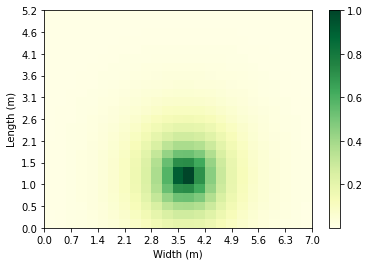

In [17]:
likelihood_grid = likelihood_grid_from_coordinates_list(
                    source_coords, room_dims, sigma=sigma)

#ax = sns.heatmap(likelihood_grid, linewidth=0, cmap="YlGnBu")

plot_grid(likelihood_grid, room_dims, log=False)


# 1. Energy ratio grid

In [4]:
# from pysoundloc.models import energy_ratio_ssl

# estimated_coords, energy_ratio_grids = energy_ratio_ssl(simulation_results[np.newaxis],
#                                                mic_coords[np.newaxis], np.array(room_dims)[np.newaxis],
#                                                sr, n_grid_points=256, return_grid_pairs=True)
    

# axs = plot_square_grid(energy_ratio_grids[0], room_dims, mic_coords, source_coords, log=True)
# # plot_grid(grid, room_dims, microphone_coords=mic_coords[[0, 1]], source_coords=source_coords, log=False)

# print(estimated_coords, source_coords)

# 2. Spatial correlation grid
Used as an input feature for localization algorithms 

[[1.13222548 3.71551796]] [[1.2387643  3.71091351 1.        ]]


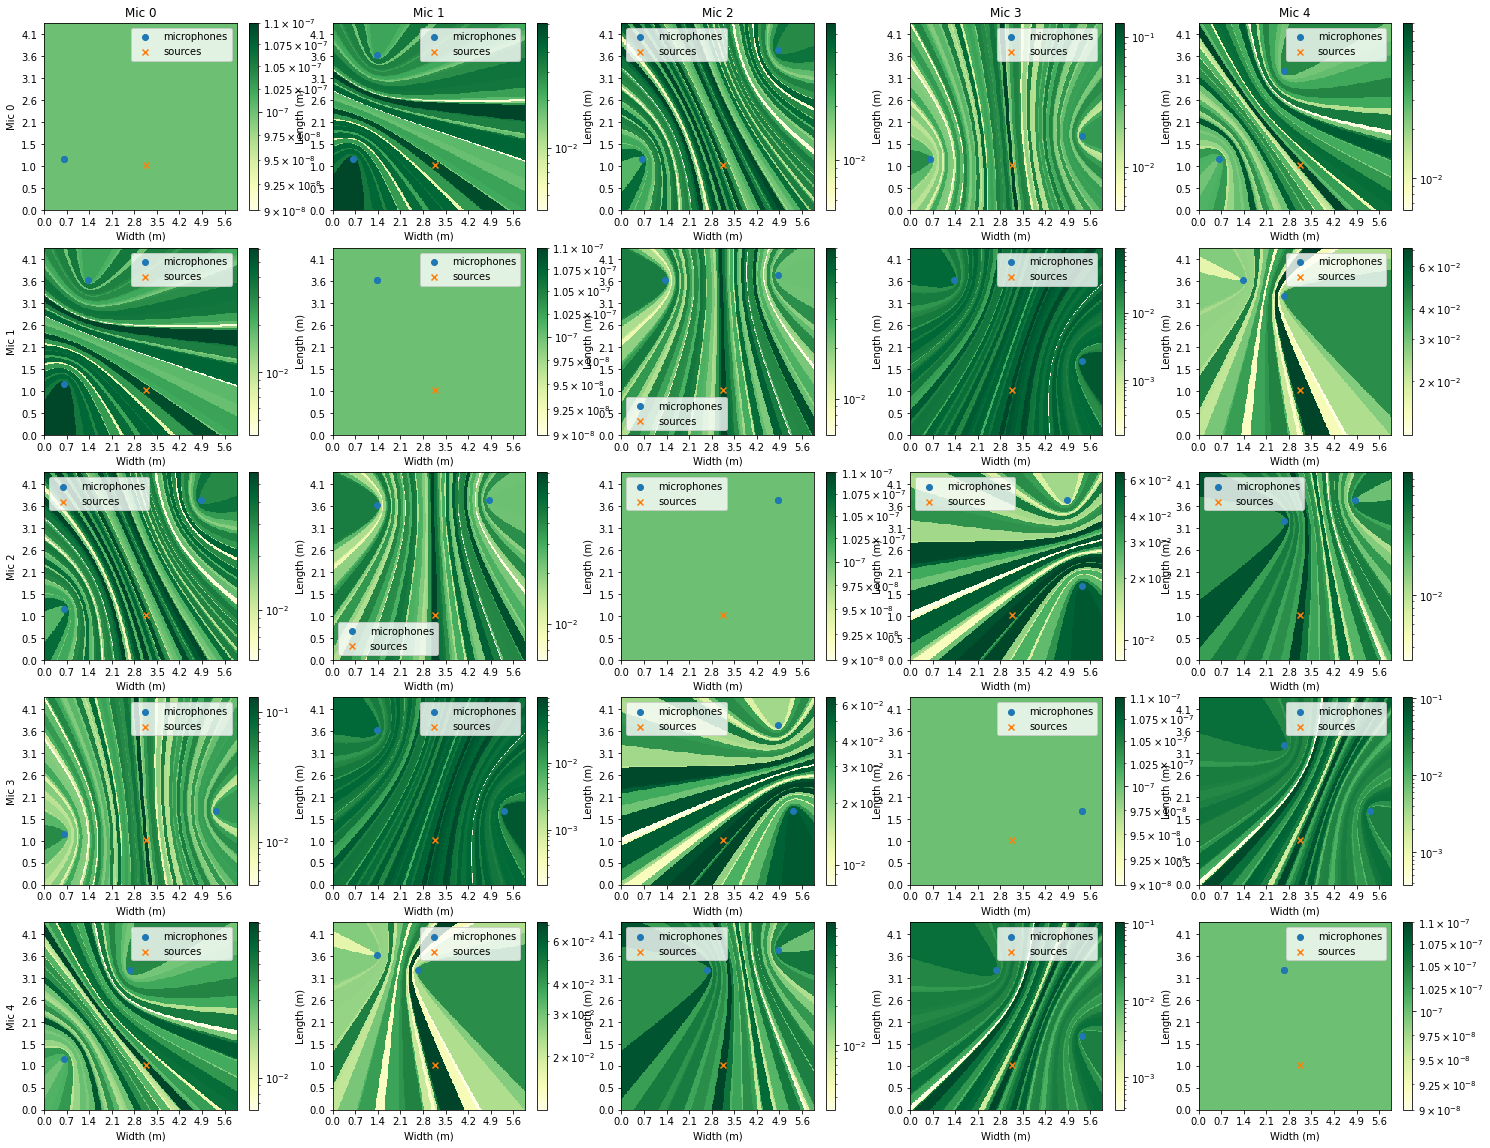

In [18]:
from pysoundloc.utils.grid import create_fixed_size_grid
from pysoundloc.models import spatial_likelihood_ssl

# Compute spatial likelihood functions for all microphones

estimated_coords, slf_grids = spatial_likelihood_ssl(simulation_results[np.newaxis],
                                   mic_coords[np.newaxis],
                                   np.array(room_dims)[np.newaxis],
                                   sr, n_grid_points=256,
                                   return_grid_pairs=True)

axs = plot_square_grid(slf_grids[0], room_dims, mic_coords, source_coords, log=True)

print(estimated_coords, source_coords)

(<matplotlib.collections.QuadMesh at 0x7fcfda40b8e0>,
 <AxesSubplot:xlabel='Width (m)', ylabel='Length (m)'>)

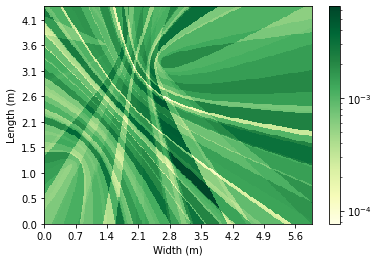

In [24]:
plot_grid(slf_grids[0, 0, 4]*slf_grids[0, 1, 4],
      room_dims,
      log=True)

(<matplotlib.collections.QuadMesh at 0x7fd0655a2730>,
 <AxesSubplot:xlabel='Width (m)', ylabel='Length (m)'>)

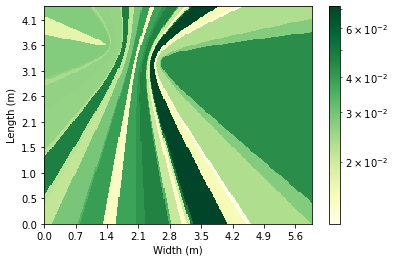

In [26]:
plot_grid(slf_grids[0, 1, 4],
      room_dims,
      log=True)

(<matplotlib.collections.QuadMesh at 0x7fd06551bb50>,
 <AxesSubplot:xlabel='Width (m)', ylabel='Length (m)'>)

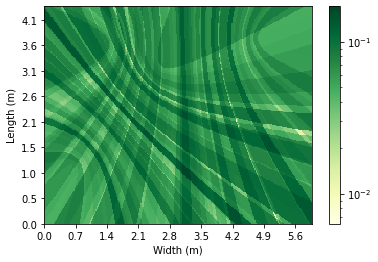

In [25]:
plot_grid(slf_grids[0, 2, 1] + slf_grids[0, 0, 4],
      room_dims,
      log=True)

## 3. TDOA grid
An alternative to the Spatial Likelihood grid

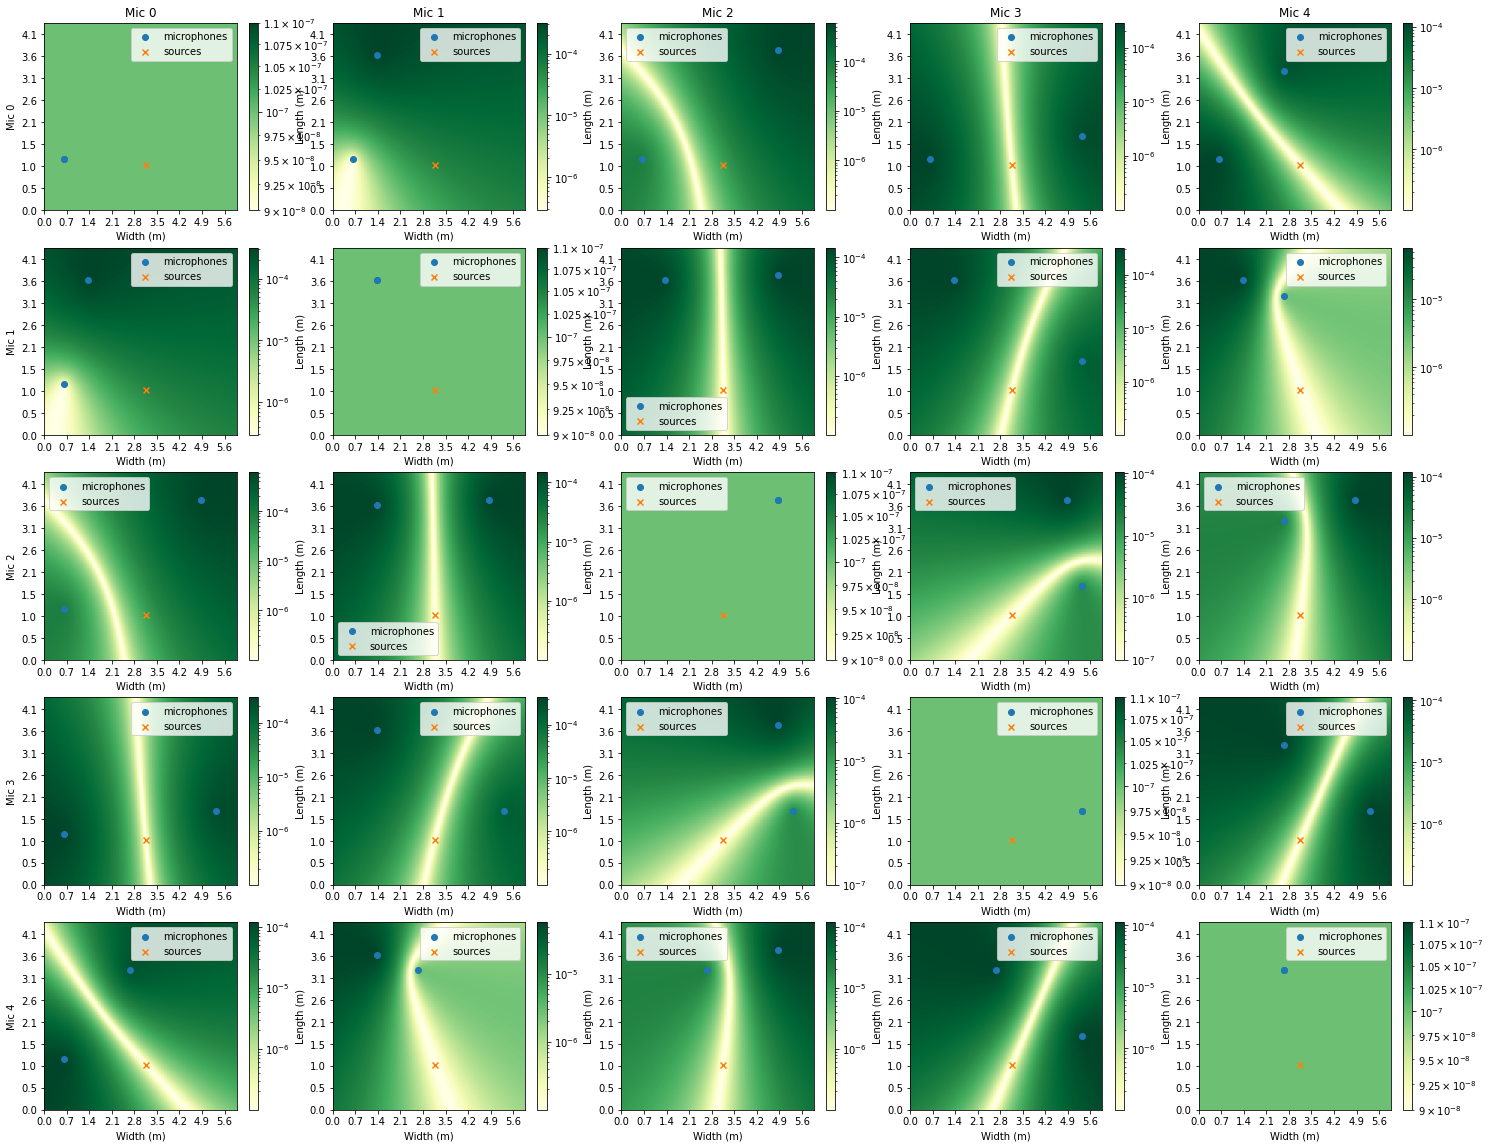

In [7]:
from pysoundloc.models import tdoa_least_squares_ssl

estimated_coords, ls_grids = tdoa_least_squares_ssl(simulation_results[np.newaxis],
                                               mic_coords[np.newaxis], np.array(room_dims)[np.newaxis],
                                               sr, n_grid_points=256, return_grid_pairs=True)
    

axs = plot_square_grid(ls_grids[0], room_dims, mic_coords, source_coords, log=True)
# plot_grid(grid, room_dims, microphone_coords=mic_coords[[0, 1]], source_coords=source_coords, log=False)

## Compare estimates using the three methods

TDOA 1.2679793771632728
SLF 0.10663827851997015


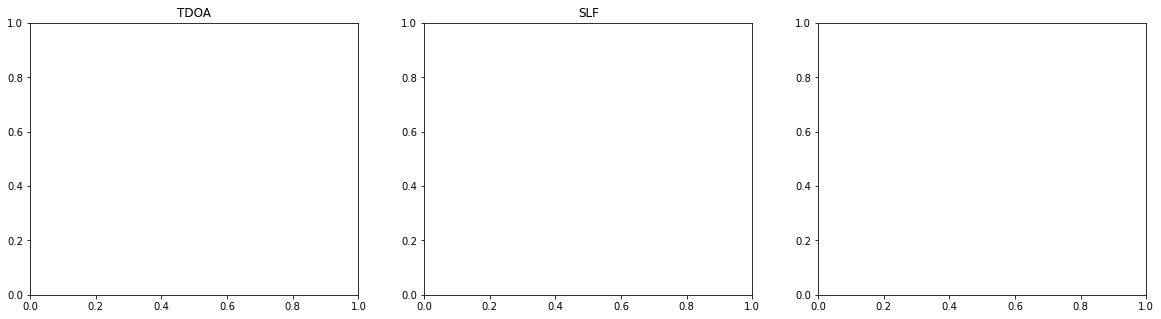

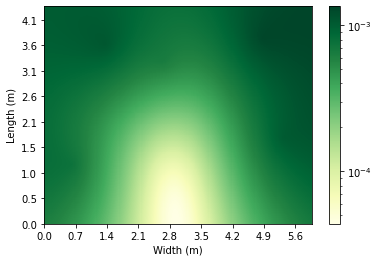

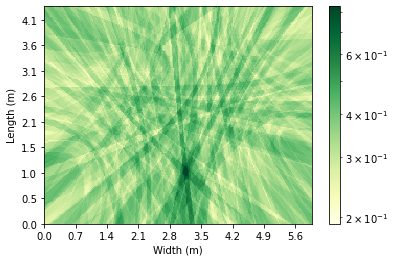

In [30]:
fig, axs = plt.subplots(ncols=3, figsize=(20, 5))

methods = {
    "TDOA": tdoa_least_squares_ssl,
    "SLF": spatial_likelihood_ssl,
    #"Energy ratios": energy_ratio_ssl,
}

for i, (method_name, method_func) in enumerate(methods.items()):
    estimated_location, grid_sum = method_func(simulation_results[np.newaxis],
                                                 mic_coords[np.newaxis],
                                                 np.array(room_dims)[np.newaxis],
                                                 sr, n_grid_points=256)#, agg_mode="sum")
    
    #grid_sum = np.clip(grid_sum, None, 1000)
    plot_grid(grid_sum[0],
          room_dims,
          microphone_coords=mic_coords,
          source_coords=source_coords,
          log=True,
          ax=axs[i])
    
    axs[i].set_title(method_name)
    
    error = np.sqrt(np.sum((estimated_location - source_coords[:, :2])**2))
    print(f"{method_name}", error)
    


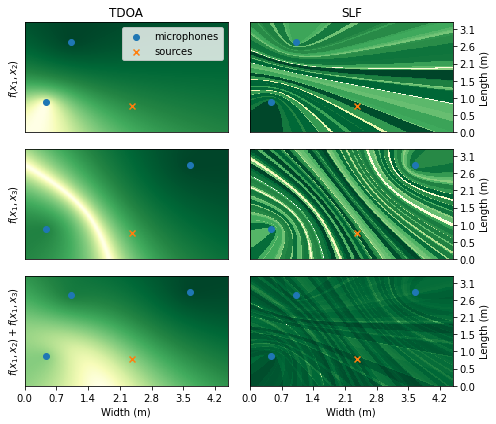

In [9]:
from matplotlib.ticker import MaxNLocator
fig, axs = plt.subplots(3, 2, figsize=(7, 6))
#plt.rcParams['text.usetex'] = False


for i in range(2):
    # Plot least squares grid
    plot_grid(ls_grids[0,0,i+1],
          room_dims,
          microphone_coords=mic_coords[[0, i+1]],
          source_coords=source_coords,
          log=True,
          ax=axs[i, 0],
          colorbar=False)
    # Plot slf grid
    plot_grid(slf_grids[0,0,i+1],
      room_dims,
      microphone_coords=mic_coords[[0, i+1]],
      source_coords=source_coords,
      log=True,
      ax=axs[i, 1],
      colorbar=False)
    
    axs[i, 0].axes.get_xaxis().set_visible(False)
    axs[i, 1].axes.get_xaxis().set_visible(False)
    axs[i, 0].set_yticks([])
    axs[i, 1].yaxis.tick_right()
        
    if i > 0:
        axs[i, 0].legend_ = None
        #axs[i, 0].axes.get_xaxis().set_visible(False)
        #axs[i, 1].axes.get_xaxis().set_visible(False)
    else:
        axs[i, 0].set_title("TDOA")
        axs[i, 1].set_title("SLF")
        axs[i, 0].set_xticks([])
        axs[i, 1].set_xticks([])
        
    axs[i, 1].legend_ = None
    
    axs[i, 0].set_ylabel(f"$f(x_{1}, x_{i+2})$")
    
    axs[i, 1].yaxis.set_major_locator(MaxNLocator(7)) 
    axs[i, 1].yaxis.tick_right()
    axs[i,1].yaxis.set_label_position("right")
# Plot the sum

plot_grid(ls_grids[0,0, 1] + ls_grids[0, 0, 2],
      room_dims,
      microphone_coords=mic_coords[[0, 1, 2]],
      source_coords=source_coords,
      log=True,
      ax=axs[-1, 0],
      colorbar=False)
        
#axs[0,-1].axes.get_yaxis().set_visible(False)
#axs[0,-1].axes.get_yaxis().set_visible(False)

plot_grid(slf_grids[0,0, 1] + slf_grids[0, 0, 2],
      room_dims,
      microphone_coords=mic_coords[[0, 1, 2]],
      source_coords=source_coords,
      log=True,
      ax=axs[-1,1],
      colorbar=False)
        
#axs[1,-1].axes.get_xaxis().set_visible(False)
#axs[1,-1].axes.get_yaxis().set_visible(False)
axs[-1,0].yaxis.tick_right()
axs[-1,1].yaxis.tick_right()
axs[-1,1].yaxis.set_label_position("right")
axs[-1,1].yaxis.set_major_locator(MaxNLocator(7)) 
axs[-1, 0].xaxis.set_major_locator(MaxNLocator(7)) 
axs[-1,1].xaxis.set_major_locator(MaxNLocator(7)) 

axs[-1, 0].set_ylabel("$f(x_{1}, x_{2}) + f(x_{1}, x_{3})$")
#axs[-1,0].axes.get_yaxis().set_visible(False)
axs[-1, 0].set_yticks([])
axs[-1, 0].legend_ = None
axs[-1, 1].legend_ = None

plt.tight_layout()
plt.savefig("f.pdf")